# Using precalculated samples arrays within the Brightway2 environment

Pascal Lesage, CIRAIG  
March 2018  

Based on an examples published in:  

Lesage, P., C. Mutel, U. Schenker and M. Margni (2018). Uncertainty analysis in LCA using precalculated aggregated datasets. The International Journal of Life Cycle Assessment. https://doi.org/10.1007/s11367-018-1444-x

-----------

## Objectives  
Show how precalculated LCIA arrays generated with the `database_wide_monte_carlo` can be used to calculate LCA scores.  
The example uses `Brightway2` and the `presamples` package.

## Fictional case study - the aluminium water bottle  
 - 150 gram water bottle made of secondary aluminium (new scrap)
 - Cradle-to-gate  
 - Only two unit processes: secondary aluminium, cold-impact extrusion.  
 - Other inputs (such as an interior polymer coating, bottle painting and packaging) are excluded from the simple example.
 - https://www.youtube.com/watch?v=ifl0-re-tV8#t=1m15s  
 - Impact method of interest: IPCC2013 GWP 100a

## Methodology

### Setting up the Brightway project and basic imports

In [1]:
from brightway2 import *

In [2]:
import numpy as np
import pandas as pd
import os
import pyprind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
iterations = 5000

In [4]:
def delete_and_setup(project_name, ecospold_dirpath, database_name):
    if project_name in projects:
        projects.delete_project(project_name, delete_dir=True)
    projects.set_current(project_name)
    bw2setup()
    importer = SingleOutputEcospold2Importer(
        dirpath=ecospold_dirpath,
        db_name = database_name
    )
    importer.apply_strategies()
    importer.write_database()
    return None

In [5]:
delete_and_setup('my_mcs_agg', r'C:\mypy\data\ecoinvent_spolds\ecoinvent34\datasets', 'db_UP')

Creating default biosphere



Writing activities to SQLite3 database:
0%                          100%
[##                            ] | ETA: 00:00:01

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.01 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 03/21/2018 00:07:13
  Finished: 03/21/2018 00:07:14
  Total time elapsed: 00:00:01
  CPU %: 67.40
  Memory %: 0.98
Created database: biosphere3
Creating default LCIA methods

Applying strategy: normalize_units
Applying strategy: set_biosphere_type
Applying strategy: drop_unspecified_subcategories
Applying strategy: link_iterable_by_fields
Applied 4 strategies in 1.45 seconds
Wrote 718 LCIA methods with 178008 characterization factors
Creating core data migrations

Extracting XML data from 14889 datasets
Extracted 14889 datasets in 31.32 seconds
Applying strategy: normalize_units
Applying strategy: remove_zero_amount_coproducts
Applying strategy: remove_zero_amount_inputs_with_no_activity
Applying strategy: remove_unnamed_parameters
Applying strategy: es2_assign_only_product_with_amount_as_reference_product
Applying strategy: assign_single_product_as_activity
Applying strategy: create_composite_code
Applying strategy: drop_unspec

Writing activities to SQLite3 database:
0%                          100%


Applied 15 strategies in 4.10 seconds


[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:13


Title: Writing activities to SQLite3 database:
  Started: 03/21/2018 00:10:01
  Finished: 03/21/2018 00:13:14
  Total time elapsed: 00:03:13
  CPU %: 62.80
  Memory %: 6.77
Created database: db_UP


In [6]:
databases

Databases dictionary with 2 object(s):
	biosphere3
	db_UP

In [7]:
db_UP = Database('db_UP')

In [8]:
if 'bottle example database' in databases: 
    Database('bottle example database').delete()
    Database('bottle example database').deregister()

### LCA without the presampled arrays

#### Identify the inputs

In [9]:
aluminium_UP = act = [act for act in db_UP if 
                   "treatment of aluminium scrap, post-consumer, prepared for recycling, at refiner" in act['name']
                   and 'aluminium, cast alloy' in act['reference product']
                   and act['location']=='RER'
                  ][0]
aluminium_UP

'treatment of aluminium scrap, post-consumer, prepared for recycling, at refiner' (kilogram, RER, None)

In [10]:
# Cold impacts extrusion
extrusion_UP = [act for act in db_UP
             if 'impact extrusion of aluminium, 1 stroke' in act['name']
            and act['location']=='RER'][0]
extrusion_UP

'impact extrusion of aluminium, 1 stroke' (kilogram, RER, None)

#### Defining the new water bottle activity programmatically

In [11]:
bottle_example_db = Database('bottle example database UP')
bottle_example_db.write(
    {('bottle example database UP', 'aluminium bottle production'): 
        {'name': 'aluminium bottle',
         'unit': 'amount', 
            'exchanges': 
            [
                {'input': aluminium_UP.key,
                 'amount': 0.150, #weight of the water bottle
                 'type': 'technosphere'},
                {'input': extrusion_UP.key,
                 'amount': 0.150, #weight of the water bottle = amount of impact extrusion required
                 'type': 'technosphere'},
                {'input': ('bottle example database UP', 'aluminium bottle production'),
                 'amount': 1,
                 'type': 'production'}
            ]
        },
    })

Writing activities to SQLite3 database:
0%  100%
[#] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/21/2018 00:15:01
  Finished: 03/21/2018 00:15:01
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 4.24


In [12]:
bottle_production_UP = get_activity(('bottle example database UP', 'aluminium bottle production'))
bottle_production_UP

'aluminium bottle' (amount, None, None)

#### Identifying the relevant LCIA impact categories

In [13]:
cc_method = [m for m in methods if 'IPCC 2013' in str(m)
                                and 'GWP' in str(m)
                                and '100' in str(m)][0]
cc_method

('IPCC 2013', 'climate change', 'GWP 100a')

In [14]:
o3_method = [m for m in methods if 'ILCD' in str(m)
                                and 'human health' in str(m)
                                and 'ozone layer depletion' in str(m)
                                and 'no LT' in str(m)][0]
o3_method

('ILCD 1.0.8 2016 midpoint no LT', 'human health', 'ozone layer depletion')

#### Carrying out the LCA on bottle production - unit processes

In [15]:
# Unit process LCA - Bottle
bottle_lca_UP = LCA({bottle_production_UP:1}, method=cc_method)
bottle_lca_UP.lci()
bottle_lca_UP.lcia()
bottle_lca_UP_cc_score = bottle_lca_UP.score
bottle_lca_UP.switch_method(o3_method)
bottle_lca_UP.lcia()
bottle_lca_UP_o3_score = bottle_lca_UP.score
bottle_lca_UP_cc_score, bottle_lca_UP_o3_score

(0.31352267634550995, 1.8287361660406905e-08)

#### Carrying out the Monte Carlo simulation on bottle production for both impact categories

In [16]:
mc_bottle_cc_UP = MonteCarloLCA({bottle_production_UP:1}, method=cc_method)
scores_bottle_cc_UP = [next(mc_bottle_cc_UP) for _ in pyprind.prog_bar(range(iterations))]
scores_arr_bottle_cc_UP = np.array(scores_bottle_cc_UP)
scores_arr_bottle_cc_UP

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:25:47


array([ 0.45838164,  0.34773437,  0.33257998, ...,  0.37121161,
        0.36620492,  0.34501008])

In [17]:
mc_bottle_o3_UP = MonteCarloLCA({bottle_production_UP:1}, method=o3_method)
scores_bottle_o3_UP = [next(mc_bottle_o3_UP) for _ in pyprind.prog_bar(range(iterations))]
scores_arr_bottle_o3_UP = np.array(scores_bottle_o3_UP)
scores_arr_bottle_o3_UP

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:23:31


array([  2.43414114e-08,   2.93892330e-08,   2.89831060e-08, ...,
         3.98467522e-08,   2.64191927e-08,   4.59791529e-08])

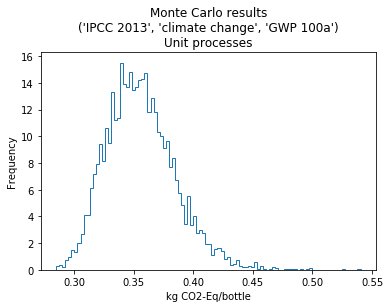

In [51]:
# CC
plt.hist(scores_arr_bottle_cc_UP, histtype='step', normed=True, bins=100)
plt.xlabel("{}/bottle".format(Method(cc_method).metadata['unit']))
plt.ylabel("Frequency")
plt.legend()
plt.title("Monte Carlo results\n{}\nUnit processes".format(cc_method));

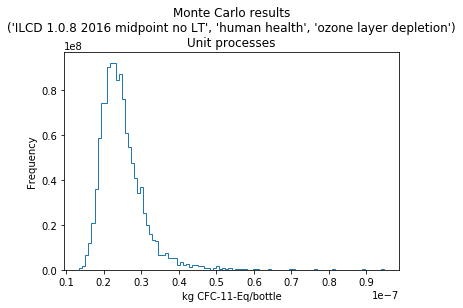

In [52]:
# O3
plt.hist(scores_arr_bottle_o3_UP, histtype='step', normed=True, bins=100)
plt.xlabel("{}/bottle".format(Method(o3_method).metadata['unit']))
plt.ylabel("Frequency")
plt.legend()
plt.title("Monte Carlo results\n{}\nUnit processes".format(o3_method));

## Aggregated datasets

The LCIA scores that were generated using `database_wide_monte_carlo` are identical to characterized aggregated LCI datasets. Before we see how to use them (Section 5), we see how to include aggregated datasets in Brightway.

### Augmenting the `biosphere3` database

The LCIA score arrays are expressed in the units of the impact categories (kg CO2-Eq, kg CFC-11-Eq). 

To be able to use the score arrays in LCA calculation (system-->inventory-->LCIA scores), we "trick" Brightway into treating these LCIA scores as elementary flows that have a characterization factor of 1. 

To do this, we first add to the database one elementary flow per impact category that represents a "unit impact per unit impact" characterization factor.  

A function that does this is found [here](https://github.com/PascalLesage/bw_utils/blob/master/augment_biosphere3.py).

To run it, simply copy the file to your computer and run it (no package, sorry).  

In [20]:
os.chdir(r'C:\mypy\code\bw_utils')

In [21]:
from augment_biosphere3 import addUnitImpactFlowsToBiosphereAndMethods

In [22]:
addUnitImpactFlowsToBiosphereAndMethods()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:01


Title: Writing activities to SQLite3 database:
  Started: 03/21/2018 01:04:22
  Finished: 03/21/2018 01:04:24
  Total time elapsed: 00:00:01
  CPU %: 60.90
  Memory %: 1.90


We can see the new characterization factor for climate change: 

In [23]:
[ef for ef in Method(cc_method).load() if Method(cc_method).get_abbreviation() in ef[0]]

[(('biosphere3', 'ipcc-2013cg.bd5af3f67229a1cc291b8ecb7f316fcf'), 1)]

Here is a short function that will copy a unit process and convert it to a characterized aggregated LCI dataset:

In [24]:
def convert_act_to_score_S(act_UP, db_S, list_methods):
    # Make sure activity and methods exist
    assert isinstance(list_methods, list), "Methods should be a list of methods"
    for m in list_methods:
        assert m in methods, "{} is not a recognized method name"
    assert "Activity" in str(type(act_UP))
    # Create a new database for S datasets if one doesn't already exist
    if db_S not in databases:
        Database(db_S).register()
    # Create a copy of the UP activity in the S database
    act_S = act_UP.copy(database=db_S, code=act_UP.key[1])
    # Remove all exchanges except the production exchange
    for exc in act_S.technosphere():
        exc.delete()
    for exc in act_S.biosphere():
        exc.delete()
    # Create an LCA object to calculate LCIA scores
    lca = LCA({act_UP:1})
    lca.lci()
    # Add LCIA scores for each method
    # The elementary flow key is ('biosphere3', method_abbreviation)
    for m in list_methods:
        new_exc = act_S.new_exchange()
        new_exc['input'] = ('biosphere3',
                            Method(m).get_abbreviation()
                           )
        new_exc['output'] = act_S.key
        lca.switch_method(m)
        lca.lcia()
        new_exc['amount'] = lca.score
        new_exc['type'] = 'biosphere'
        new_exc.save()
    # Save the activity
    act_S.save()
    return act_S

First, let's convert the aluminium dataset:

In [25]:
aluminium_S = convert_act_to_score_S(aluminium_UP, 'bd_S', [cc_method, o3_method])

In [26]:
aluminium_S

'treatment of aluminium scrap, post-consumer, prepared for recycling, at refiner' (kilogram, RER, None)

Let's make sure it does not have any technosphere inputs:

In [27]:
[*aluminium_S.technosphere()]

[]

It should only have two elementary flows: 

In [28]:
[*aluminium_S.biosphere()]

[Exchange: 1.0485063442987095 kg CO2-Eq 'Unit impact for ('IPCC 2013', 'climate change', 'GWP 100a')' (kg CO2-Eq, None, ('undefined',)) to 'treatment of aluminium scrap, post-consumer, prepared for recycling, at refiner' (kilogram, RER, None)>,
 Exchange: 6.412753664966969e-08 kg CFC-11-Eq 'Unit impact for ('ILCD 1.0.8 2016 midpoint no LT', 'human health', 'ozone layer depletion')' (kg CFC-11-Eq, None, ('undefined',)) to 'treatment of aluminium scrap, post-consumer, prepared for recycling, at refiner' (kilogram, RER, None)>]

The score of the LCA for an aggregated activity should be the same as that of a unit process:

In [29]:
# Unit process LCA
alu_lca_UP = LCA({aluminium_UP:1}, method=cc_method)
alu_lca_UP.lci()
alu_lca_UP.lcia()
alu_lca_UP_cc_score = alu_lca_UP.score
alu_lca_UP.switch_method(o3_method)
alu_lca_UP.lcia()
alu_lca_UP_o3_score = alu_lca_UP.score

# Aggregated process LCA 
alu_lca_S = LCA({aluminium_S:1}, method=cc_method)
alu_lca_S.lci()
alu_lca_S.lcia()
alu_lca_S_cc_score = alu_lca_S.score
alu_lca_S.switch_method(o3_method)
alu_lca_S.lcia()
alu_lca_S_o3_score = alu_lca_S.score

# Comparison
alu_lca_UP_cc_score/alu_lca_S_cc_score, alu_lca_UP_o3_score/alu_lca_S_o3_score

(0.9999999667824692, 1.0000000490284213)

Let's generate an aggregated dataset for extrusion as well:

In [30]:
extrusion_S = convert_act_to_score_S(extrusion_UP, 'bd_S', [cc_method, o3_method])

And a new bottle activity that uses the aggregated datasets rather than the unit processes:

In [31]:
bottle_example_db = Database('bottle example database S')
bottle_example_db.write(
    {('bottle example database S', 'aluminium bottle production'): 
        {'name': 'aluminium bottle',
         'unit': 'amount', 
            'exchanges': 
            [
                {'input': aluminium_S.key,
                 'amount': 0.150, #weight of the water bottle
                 'type': 'technosphere'},
                {'input': extrusion_S.key,
                 'amount': 0.150, #weight of the water bottle = amount of impact extrusion required
                 'type': 'technosphere'},
                {'input': ('bottle example database S', 'aluminium bottle production'),
                 'amount': 1,
                 'type': 'production'}
            ]
        },
    })

Writing activities to SQLite3 database:
0%  100%
[#] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/21/2018 01:05:08
  Finished: 03/21/2018 01:05:08
  Total time elapsed: 00:00:00
  CPU %: 390.60
  Memory %: 2.62


In [32]:
bottle_production_S = get_activity(('bottle example database S', 'aluminium bottle production'))
bottle_production_S

'aluminium bottle' (amount, None, None)

Again, the LCA score for the water bottle should be the same using aggregated datasets as when using the unit process database:

In [33]:
# Aggregated process LCA - Bottle
bottle_lca_S = LCA({bottle_production_S:1}, method=cc_method)
bottle_lca_S.lci()
bottle_lca_S.lcia()
bottle_lca_S_cc_score = bottle_lca_S.score
bottle_lca_S.switch_method(o3_method)
bottle_lca_S.lcia()
bottle_lca_S_o3_score = bottle_lca_S.score

In [34]:
bottle_lca_S_cc_score/bottle_lca_UP_cc_score, bottle_lca_S_o3_score/bottle_lca_UP_o3_score 

(0.9999999899370294, 0.9999999722343805)

However, uncertainty analysis cannot be done on the bottle with aggregated datasets: the LCIA scores used in the creation of the activity have no uncertainty: 

In [35]:
mc_bottle_cc_S = MonteCarloLCA({bottle_production_S:1}, method=cc_method)
scores_bottle_cc_S = [next(mc_bottle_cc_S) for _ in pyprind.prog_bar(range(iterations))]
scores_arr_bottle_cc_S = np.array(scores_bottle_cc_S)
scores_arr_bottle_cc_S

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:06


array([ 0.31352267,  0.31352267,  0.31352267, ...,  0.31352267,
        0.31352267,  0.31352267])

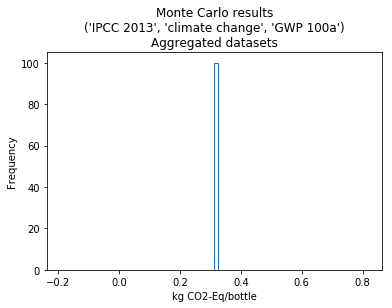

In [53]:
# CC
plt.hist(scores_arr_bottle_cc_S, histtype='step', normed=True, bins=100)
plt.xlabel("{}/bottle".format(Method(cc_method).metadata['unit']))
plt.ylabel("Frequency")
plt.legend()
plt.title("Monte Carlo results\n{}\nAggregated datasets".format(cc_method));

## Presamples

The precalculated arrays can be integrated in the LCA calculations by using the `presamples` library (see repo [here](https://github.com/PascalLesage/brightway2-presamples/tree/master)). It was codeveloped by Pascal Lesage (CIRAIG) and Chris Mutel (PSI, main developer of the Brightway2 Framework) as a means to integrate precalculated samples directly in LCA. It has many other applications, but the core motivation at the start was to be able to incude the results of arrays such as those generated by `database_wide_monte_carlo`.

As of March 20, 2018, the `presamples` package can be installed directly using pip. In the conda environment where `Brightway2` is installed, simply type `pip install presamples`. 

They can then be imported:

In [37]:
import presamples as ps

To use the precalculated presamples in LCA, follow the following steps:

### Generate the matrix_data

Precalculated samples for use in LCA matrices need to be organized in a list of `(samples, indices, matrix label)`.

* `samples` are a two-dimensional Numpy array, where each row contains values for a specific matrix element that will be replaced and each column contains values for a given realization of the LCA model.
* `indices` is an iterable with row and (usually) column indices. The *ith* element of `indices` refers to the *ith* row of the `samples`. The indices of elements of the $\mathbf{A}$ and $\mathbf{B}$ matrices have the format `[(input id, output id, type)]`. The ``type`` is an exchange type, i.e. one of "production", "technosphere", "biosphere", or "substitution".
*  `matrix label` is a string giving the name of the matrix to be modified in the LCA class. This string is normally, but not necessarily, one of `('technosphere', 'biosphere', 'cf')`.

In the case of our aggregated LCIA scores, we have four matrix elements for which we want use precalculated:  
* Climate change scores for the aluminium aggregated activity    
* Climate change scores for the extrusion aggregated activity    
* Ozone layer depletion scores for the aluminium aggregated activity    
* Ozone layer depletion scores for the extrusion aggregated activity    

#### Samples  
The samples are basically the four calculated LCIA arrays horizontally stacked, leading to an array of shape (4, 5000).  
Here is how to get them:

In [38]:
# Directory with LCIA scores
lcia_fp = r'c:/mypy/data/my_mcs/db/results/LCIA'

# The subdirectory name is the abbreviation of the LCIA method
# The file name is the code of the activity (i.e. the second element of the activity's key)
# To generate a single array, as described above:

# Generate a list of arrays
arrays_list = [np.load(os.path.join(lcia_fp, Method(m).get_abbreviation(), act.key[1]+'.npy'))
              for  act in [aluminium_S, extrusion_S]
              for m in [cc_method, o3_method]
              ]
# Reshape arrays from (5000,) to (5000, 1) 
arrays_list = [arr.reshape(-1, 1) for arr in arrays_list]

# Stack the arrays
samples = np.hstack(arrays_list)

# Transpose from a (5000,4) array to a (4, 5000) array
samples = samples.T

In [39]:
samples

array([[  1.12598808e+00,   1.19107325e+00,   1.16119797e+00, ...,
          1.07931717e+00,   1.25014010e+00,   1.18317415e+00],
       [  7.30755270e-08,   1.03364491e-07,   7.67967139e-08, ...,
          8.98991157e-08,   1.21543735e-07,   8.31902434e-08],
       [  1.08553357e+00,   1.07559776e+00,   1.16737192e+00, ...,
          1.27067617e+00,   1.20333520e+00,   1.25096477e+00],
       [  7.26152234e-08,   9.50454007e-08,   6.10345342e-08, ...,
          9.81565533e-08,   9.66410216e-08,   8.50814043e-08]])

In [40]:
samples.shape

(4, 5000)

#### Indices  
The indices refer to our four "unit impact" flows that we use to store LCIA results. Here is how to generate them:

In [41]:
samples

array([[  1.12598808e+00,   1.19107325e+00,   1.16119797e+00, ...,
          1.07931717e+00,   1.25014010e+00,   1.18317415e+00],
       [  7.30755270e-08,   1.03364491e-07,   7.67967139e-08, ...,
          8.98991157e-08,   1.21543735e-07,   8.31902434e-08],
       [  1.08553357e+00,   1.07559776e+00,   1.16737192e+00, ...,
          1.27067617e+00,   1.20333520e+00,   1.25096477e+00],
       [  7.26152234e-08,   9.50454007e-08,   6.10345342e-08, ...,
          9.81565533e-08,   9.66410216e-08,   8.50814043e-08]])

In [42]:
# The subdirectory name is the abbreviation of the LCIA method
# The file name is the code of the activity (i.e. the second element of the activity's key)
# To generate a single array, as described above:
indices = []
for act in [aluminium_S, extrusion_S]:
    for m in [cc_method, o3_method]:
        indices.append(
            (
                ('biosphere3', Method(m).get_abbreviation()),
                act.key,
                'biosphere'
            )
        )
indices

[(('biosphere3', 'ipcc-2013cg.bd5af3f67229a1cc291b8ecb7f316fcf'),
  ('bd_S', '752f34fa1a0c7a9c7b2b5d8d52c940e8'),
  'biosphere'),
 (('biosphere3',
   'ilcd-108-2016-midpoint-no-ltho.3039615a2eeeb07c0a5dbc9266b013db'),
  ('bd_S', '752f34fa1a0c7a9c7b2b5d8d52c940e8'),
  'biosphere'),
 (('biosphere3', 'ipcc-2013cg.bd5af3f67229a1cc291b8ecb7f316fcf'),
  ('bd_S', 'f3986f0a13837b31a3130fc4fecc617a'),
  'biosphere'),
 (('biosphere3',
   'ilcd-108-2016-midpoint-no-ltho.3039615a2eeeb07c0a5dbc9266b013db'),
  ('bd_S', 'f3986f0a13837b31a3130fc4fecc617a'),
  'biosphere')]

The label is `'biosphere'`, since our aggregated LCIA scores have been converted to elementary flows: 

In [43]:
label = 'biosphere'

In [44]:
agg_matrix_data = [(samples, indices, label)]

### Creating a presamples package

The formatted data can now be used to create a presamples package. This stores the data in the Brightway project folder and allows it to be efficiently retrieved on demand, notably during LCA.  
The function returns an id and the filepath where the presamples package is saved.

In [45]:
ps_id, ps_fp = ps.create_presamples_package(matrix_data=agg_matrix_data)

In [46]:
ps_fp

WindowsPath('C:/Users/Pascal Lesage/AppData/Local/pylca/Brightway3/my_mcs_agg.dc1afbf1e98660c6480e2b06c615ade3/presamples/8ddce3848a4d45138e1321c246c3360d')

### Using the presamples package

To use the precalculated samples directly in a `MonteCarloLCA`, simply pass the presamples package filepath as an argument. One can pass a list of such filepaths, but in our case we just have 1. The values for the matrix elements specified in the indices are replaced on each iteration by a random sample from our sample array (all taken from the same column).  
To pass the samples in order, the argument `seed=sequential` should have been passed when creating the presamples package.

Notice the speed!

In [47]:
mc_bottle_cc_ps = MonteCarloLCA(
    {bottle_production_S:1},
    method=cc_method,
    presamples=[ps_fp]
)
scores_bottle_cc_ps = [next(mc_bottle_cc_ps) for _ in pyprind.prog_bar(range(iterations))]
scores_arr_bottle_cc_ps = np.array(scores_bottle_cc_ps)
scores_arr_bottle_cc_ps

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:07


array([ 0.36562162,  0.34342905,  0.28846223, ...,  0.35133616,
        0.34493964,  0.34548213])

In [48]:
mc_bottle_o3_ps = MonteCarloLCA(
    {bottle_production_S:1},
    method=o3_method,
    presamples=[ps_fp]
)
scores_bottle_o3_ps = [next(mc_bottle_o3_ps) for _ in pyprind.prog_bar(range(iterations))]
scores_arr_bottle_o3_ps = np.array(scores_bottle_o3_ps)
scores_arr_bottle_o3_ps

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:07


array([  2.22330078e-08,   1.86214634e-08,   2.15619042e-08, ...,
         2.37445899e-08,   2.66586824e-08,   1.81934170e-08])

The results can be plotted along with those obtained with the Monte Carlo analysis using unit processes.

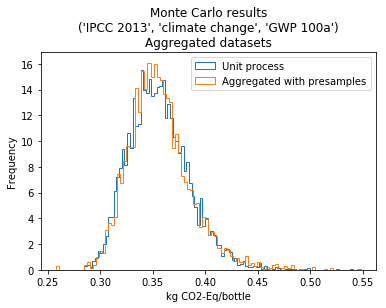

In [54]:
# CC
plt.hist(scores_arr_bottle_cc_UP, histtype='step', normed=True, label="Unit process", bins=100)
plt.hist(scores_arr_bottle_cc_ps, histtype='step', normed=True, label="Aggregated with presamples", bins=100)
plt.xlabel("{}/bottle".format(Method(cc_method).metadata['unit']))
plt.ylabel("Frequency")
plt.legend()
plt.title("Monte Carlo results\n{}\nAggregated datasets".format(cc_method));

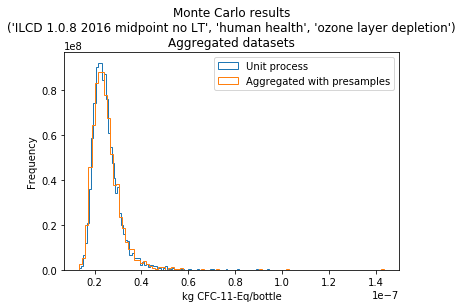

In [55]:
# o3
plt.hist(scores_arr_bottle_o3_UP, histtype='step', normed=True, label="Unit process", bins=100)
plt.hist(scores_arr_bottle_o3_ps, histtype='step', normed=True, label="Aggregated with presamples", bins=100)
plt.xlabel("{}/bottle".format(Method(o3_method).metadata['unit']))
plt.ylabel("Frequency")
plt.legend()
plt.title("Monte Carlo results\n{}\nAggregated datasets".format(o3_method));